# **Text mining: SENTIMENT ANALYSIS**

## 🎓 Master’s Program in Data Science & Advanced Analytics  
**Nova IMS** | March 2025  
**Course:** Business Cases with Data Science

## 👥 Team **Group 34**  
- **[Philippe Dutranoit]** | [20240518]  
- **[Diogo Duarte]** | [20240525]  
- **[Rui luz]** | [20211628]  
- **[Rodrigo Sardinha]** | [20211627]  

## 📊 Goal of the notebook

This notebook focuses on feature selection and engineering for our text-mining project: predicting market sentiment (Bearish, Bullish, Neutral) from Twitter data.  


# Imports

In [19]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, RobertaForSequenceClassification, pipeline

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
X_train = pd.read_csv('../Data/X_train.csv')
y_train = pd.read_csv('../Data/y_train.csv')
X_test = pd.read_csv('../Data/X_val.csv')
y_test = pd.read_csv('../Data/y_val.csv')

# Prepocessing 

In [3]:
# Define the model 
MODEL_NAME = 'cardiffnlp/twitter-roberta-base-sentiment-latest'

## Preprocessing with a tokenizer

### Define tokenizer

In [4]:
# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

c:\Users\ruibl\anaconda3\envs\nel_2025_env_full\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Use a pre-trained Pipeline

Here we are using the Huggingface pipeline("sentiment-analysis") to evaluate the performance of a pre-trained Transformer model on our validation set. The model is used in inference mode only, without being trained on our data. Providing a baseline to compare later with our own fine-tuned model.

In [5]:
# Load pipeline
classifier = pipeline(
    "sentiment-analysis",
    model=MODEL_NAME,
    tokenizer=MODEL_NAME,
    batch_size=16,
    device_map="auto",
    truncation=True
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Run pipeline on validation set

In [6]:
# Prepare texts
val_texts = X_test["text"].tolist()

# Run pipeline on full validation set
preds = classifier(val_texts)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


#### Map predicted labels to int

In [7]:
# Map label to int
label_map = {
    "negative": 0,  # Bearish
    "positive": 1,  # Bullish
    "neutral": 2    # Neutral
}

y_pred_pipeline = [label_map[pred['label']] for pred in preds]

#### Evaluate

In [8]:
# True labels
y_true = y_test["label"].tolist()

# Print evaluation metrics
print(classification_report(y_true, y_pred_pipeline, digits=4))

              precision    recall  f1-score   support

           0     0.4907    0.4583    0.4740       288
           1     0.6084    0.4519    0.5186       385
           2     0.7371    0.8074    0.7707      1236

    accuracy                         0.6831      1909
   macro avg     0.6121    0.5726    0.5878      1909
weighted avg     0.6740    0.6831    0.6751      1909



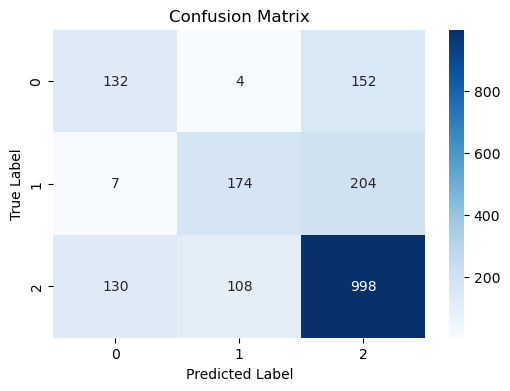

In [20]:
cm = confusion_matrix(y_true, y_pred_pipeline)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Model Training 

# Train our own Bert Model

### Encode the dataset

In [9]:
# Tokenize training set
train_encodings = tokenizer(
    X_train["text"].tolist(),   # convert to list of strings
    padding=True,               # pad to max length in batch
    truncation=True,            # truncate long tweets
    return_tensors="pt"         # return PyTorch tensors
)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [10]:
# Tokenize validation set
val_encodings = tokenizer(
    X_test["text"].tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt"
)

In [11]:
# Check shape of tokenized data
print("Train input_ids shape:", train_encodings["input_ids"].shape)
print("Validation input_ids shape:", val_encodings["input_ids"].shape)

Train input_ids shape: torch.Size([7634, 105])
Validation input_ids shape: torch.Size([1909, 83])


### Dataset and DataLoader

In [12]:
# Custom Dataset class for our BERT model
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item


#### Instantiate dataset

In [13]:
# Convert labels to list
train_labels = y_train["label"].tolist()
val_labels = y_test["label"].tolist()

# Create Dataset objects
train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)

#### Create DataLoaders

In [14]:
# Set batch size (typical: 16 or 32)
batch_size = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [15]:
# Check one batch from train_loader
batch = next(iter(train_loader))
print(batch.keys())
print(batch['input_ids'].shape)
print(batch['attention_mask'].shape)
print(batch['labels'].shape)

dict_keys(['input_ids', 'attention_mask', 'labels'])
torch.Size([16, 105])
torch.Size([16, 105])
torch.Size([16])


## Model prep 

## Load the model

In [16]:
# Load model with 3 output labels
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

c:\Users\ruibl\anaconda3\envs\nel_2025_env_full\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenc

In [17]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

## Setup model training

## Model Training 